In [1]:
import sys
import joblib
import os
import scipy.io as sio
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.pca import PCA_AE
from src.models.mlp import MLP_AE
from src.models.cnn import CNN_AE

from src.utils import *

In [3]:
project = 'fvcom'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.makedirs(f'{project_root}/src/models/checkpoints/{project}', exist_ok=True)

load_existing_models = False
latent_dim = 75

In [5]:
u1 = np.load(f'{project_root}/data/{project}/u_interp.npy') 
u2 = np.load(f'{project_root}/data/{project}/v_interp.npy')
t = np.load(f'{project_root}/data/{project}/t.npy')
reference_date = pd.Timestamp("2005-01-01")
datetimes = [reference_date + pd.to_timedelta(days - 732313.0, unit='D') for days in t]

nt, n1, n2 = u1.shape
mask = ~np.isnan(u1[0,:,:])

X, scaler = transform_data_for_AE(u1,u2)

mask_tensor = torch.tensor(mask).bool()

def mask_loss(recon_x, x):
    batch_size = x.size(0)
    mask_expanded = mask_tensor.unsqueeze(0).unsqueeze(0).expand(batch_size, x.size(1), n1, n2)
    return nn.MSELoss()(recon_x[mask_expanded], x[mask_expanded])

print(f"Data shape: {X.shape}, Mask shape: {mask.shape}")

Data shape: (15475, 2, 64, 64), Mask shape: (64, 64)


In [6]:
# === Consistent train/val/test split ===
n_train = int(0.5 * nt)
n_val = int(0.2 * nt)
n_test = nt - n_train - n_val

train_idx = np.arange(0, n_train)
val_idx = np.arange(n_train, n_train + n_val)
test_idx = np.arange(n_train + n_val, nt)

X_train = X[train_idx]
X_val = X[val_idx]
X_test = X[test_idx]

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")
print(f"Training dates: {datetimes[train_idx[0]][0].date()} to {datetimes[train_idx[-1]][0].date()}, Validation dates: {datetimes[val_idx[0]][0].date()} to {datetimes[val_idx[-1]][0].date()}, Test dates: {datetimes[test_idx[0]][0].date()} to {datetimes[test_idx[-1]][0].date()}")

train_dataset = TensorDataset(torch.tensor(X_train).float())
val_dataset = TensorDataset(torch.tensor(X_val).float())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

Train shape: (7737, 2, 64, 64), Val shape: (3095, 2, 64, 64), Test shape: (4643, 2, 64, 64)
Training dates: 2005-01-01 to 2009-06-06, Validation dates: 2009-06-06 to 2011-04-09, Test dates: 2011-04-09 to 2013-12-31


In [7]:
# === PCA Model ===
if load_existing_models and os.path.exists(f'{project_root}/src/models/checkpoints/{project}/pca_{latent_dim}_model.pkl'):
    pca = PCA_AE.load(f'{project_root}/src/models/checkpoints/{project}/pca_{latent_dim}_model.pkl')
else:
    pca = PCA_AE(latent_dim=latent_dim, mask=mask)
    pca.train(X_train)
    pca.save(f'{project_root}/src/models/checkpoints/{project}/pca_{latent_dim}_model.pkl')

/home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/1000 - Train Loss: 0.2847 - Val Loss: 0.1722 - LR: 0.001000
Epoch 2/1000 - Train Loss: 0.1673 - Val Loss: 0.1451 - LR: 0.001000
Epoch 3/1000 - Train Loss: 0.1434 - Val Loss: 0.1190 - LR: 0.001000
Epoch 4/1000 - Train Loss: 0.1288 - Val Loss: 0.1145 - LR: 0.001000
Epoch 5/1000 - Train Loss: 0.1213 - Val Loss: 0.1075 - LR: 0.001000
Epoch 6/1000 - Train Loss: 0.1160 - Val Loss: 0.1032 - LR: 0.001000
Epoch 7/1000 - Train Loss: 0.1124 - Val Loss: 0.0973 - LR: 0.001000
Epoch 8/1000 - Train Loss: 0.1092 - Val Loss: 0.0965 - LR: 0.001000
Epoch 9/1000 - Train Loss: 0.1068 - Val Loss: 0.0931 - LR: 0.001000
Epoch 10/1000 - Train Loss: 0.1062 - Val Loss: 0.0954 - LR: 0.001000
Epoch 11/1000 - Train Loss: 0.1033 - Val Loss: 0.0949 - LR: 0.001000
Epoch 12/1000 - Train Loss: 0.1030 - Val Loss: 0.0942 - LR: 0.001000
Epoch 13/1000 - Train Loss: 0.1014 - Val Loss: 0.0912 - LR: 0.001000
Epoch 14/1000 - Train Loss: 0.1005 - Val Loss: 0.0902 - LR: 0.001000
Epoch 15/1000 - Train Loss: 0.0996 - Val Lo

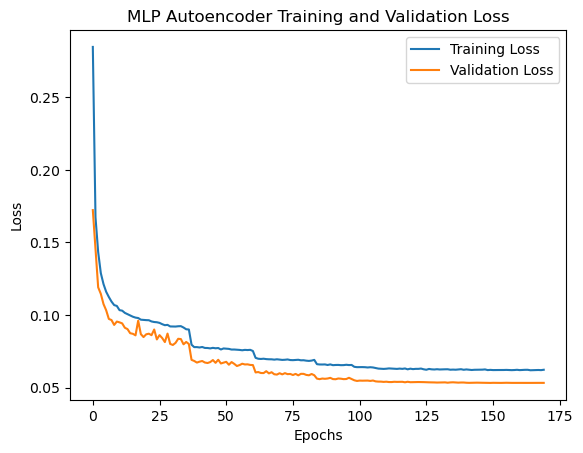

In [8]:
# === MLP Autoencoder ===
mlp_input_dim = X[:, :, mask].reshape(X.shape[0], -1).shape[1]

mlp = MLP_AE(input_dim=mlp_input_dim, latent_dim=latent_dim, mask=mask)
if load_existing_models and os.path.exists(f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_model.pth'):
    mlp.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_model.pth'))
    training_loss_mlp = np.load(f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_training_loss.npy')
    validation_losses_mlp = np.load(f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_validation_losses.npy')
else:
    training_loss_mlp, validation_losses_mlp = mlp.train_model(
                                                    train_loader=train_loader,
                                                    val_loader=val_loader,
                                                    device=device,
                                                    loss_fn=mask_loss,
                                                    patience=20,
                                                    lr=1e-3,
                                                    save_path=f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_model.pth'
                                                )
    np.save(f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_training_loss.npy', training_loss_mlp)
    np.save(f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_validation_losses.npy', validation_losses_mlp)

plt.plot(training_loss_mlp, label='Training Loss')
plt.plot(validation_losses_mlp, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLP Autoencoder Training and Validation Loss')
plt.legend()

/home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1719512383855/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/1000], Training Loss: 0.3528, Validation Loss: 0.2088, LR: 1.000000e-03
Epoch [2/1000], Training Loss: 0.1779, Validation Loss: 0.1821, LR: 1.000000e-03
Epoch [3/1000], Training Loss: 0.1462, Validation Loss: 0.1411, LR: 1.000000e-03
Epoch [4/1000], Training Loss: 0.1241, Validation Loss: 0.1637, LR: 1.000000e-03
Epoch [5/1000], Training Loss: 0.1132, Validation Loss: 0.1106, LR: 1.000000e-03
Epoch [6/1000], Training Loss: 0.1023, Validation Loss: 0.1037, LR: 1.000000e-03
Epoch [7/1000], Training Loss: 0.0999, Validation Loss: 0.1161, LR: 1.000000e-03
Epoch [8/1000], Training Loss: 0.0922, Validation Loss: 0.1131, LR: 1.000000e-03
Epoch [9/1000], Training Loss: 0.0881, Validation Loss: 0.0929, LR: 1.000000e-03
Epoch [10/1000], Training Loss: 0.0838, Validation Loss: 0.0883, LR: 1.000000e-03
Epoch [11/1000], Training Loss: 0.0787, Validation Loss: 0.0813, LR: 1.000000e-03
Epoch [12/1000], Training Loss: 0.0784, Validation Loss: 0.0863, LR: 1.000000e-03
Epoch [13/1000], Training

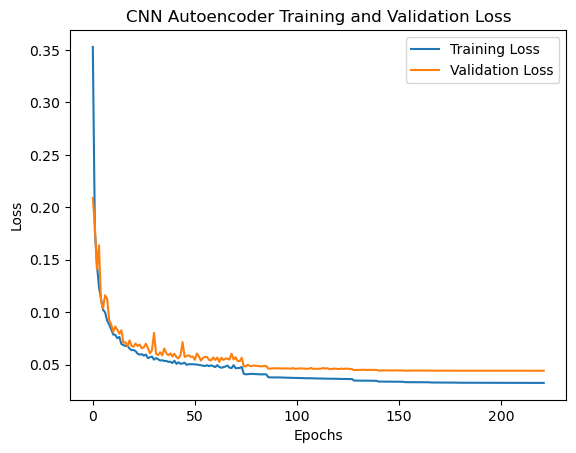

In [9]:
# === CNN Autoencoder with mask-aware loss === #

# Create DataLoader from TensorDataset
train_dataset = TensorDataset(torch.tensor(X_train).float())
val_dataset = TensorDataset(torch.tensor(X_val).float())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16)

# Instantiate CNN and train with the mask-aware loss
cnn = CNN_AE(latent_dim=latent_dim)
if load_existing_models and os.path.exists(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_model.pth'):
    cnn.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_model.pth'))
    training_losses_cnn = np.load(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_training_loss.npy')
    validation_losses_cnn = np.load(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_validation_losses.npy')
else:
    training_losses_cnn, validation_losses_cnn = cnn.train_model(
                                                    train_loader,
                                                    val_loader=val_loader,
                                                    device=device,
                                                    loss_fn=mask_loss,
                                                    patience=20,
                                                    lr=1e-3,
                                                    save_path=f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_model.pth')
    np.save(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_training_loss.npy', training_losses_cnn)
    np.save(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_validation_losses.npy', validation_losses_cnn)

plt.plot(training_losses_cnn, label='Training Loss')
plt.plot(validation_losses_cnn, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Autoencoder Training and Validation Loss')
plt.legend()